# This python notebook is to assist my program developing process and save useful images and discussion for the writeup.

### Import packages

In [1]:
# Import useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math

### Load Driving_log data

In [2]:
# Set the driving_log.scv file path
csv_path = './Behavior_Cloning_Data/driving_log.csv'

# Use panda to read the csv file
data_record = pd.read_csv(csv_path, index_col = False)
data_record['direction'] = pd.Series('s', index = data_record.index)

# Show the columns of the data sheet
data_record.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed',
       'direction'],
      dtype='object')

### Show the steer signal along frames in time sequence

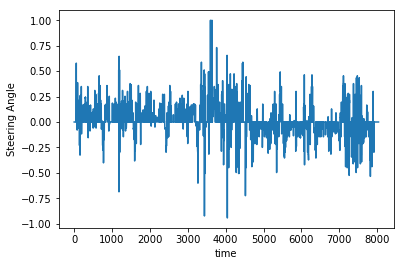

In [3]:
plot_len = 20000
data_steer = np.array(data_record.steering, dtype = np.float32)
time = np.arange(len(data_steer))
plt.plot(time[0:plot_len], data_steer[0:plot_len])
plt.xlabel('time')
plt.ylabel('Steering Angle')
# steer_sm = data_steer
# data_record['steer_sm'] = pd.Series(steer_sm, index=data_record.index)

From this chart, we can tell the vehicle is driving clockwise along the course since the steering angle has more positive than negative.  

### Show the speed log


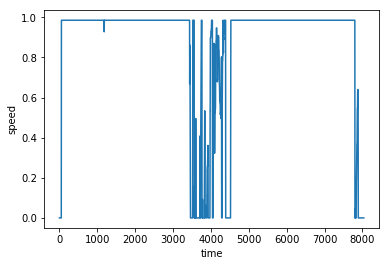

In [4]:
data_speed = np.array(data_record.throttle, dtype = np.float32)
plt.plot(time[0:plot_len], data_speed[0:plot_len])
plt.xlabel('time')
plt.ylabel('speed')

### Remove the throttle below 0.25 to exclude the initial, final, and some of the driving-straight state

In [5]:
ind_del = data_record['throttle'] > 0.25
data_record = data_record[ind_del].reset_index()

## Image preprocess

In [6]:
# Define a image function loading and normalizing the input image
def image_new_norm(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255.0 - 0.5
    return img

### Image Augmentation 1: Including Left and Right images

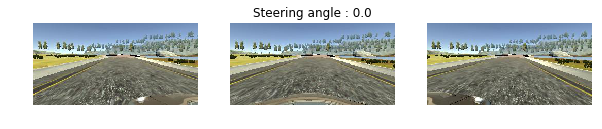

In [7]:
image_num = 16 # pick a random image
image_center = image_new_norm('Behavior_Cloning_Data/'+data_record['center'][image_num].strip())
image_left = image_new_norm('Behavior_Cloning_Data/'+data_record['left'][image_num].strip())
image_right = image_new_norm('Behavior_Cloning_Data/'+data_record['right'][image_num].strip())
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.imshow(image_left+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_center+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(data_record['steering'][image_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_right+.5);
plt.axis('off');

To use the left and right images, I shift the right  camera to the left by subtracting .25 and left camera to the right by adding .25. This shifting parameter is turned and tested in the training and validation step.

### Image Augmentation 2：Brightness augmentation

Thanks to the Vivek Yadav's post. I add this step to accomodate the model to both day and night driving environments, although it is not necessary to this project. I used the HSV scale and randomly adjusted the 'V' value by a scale from 0.2 to 1.2. The returning image is converted back to RGB.

In [8]:
def augment_brightness(image):
    imageHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random = 0.2 + np.random.uniform()
    imageHSV[:,:,2] = imageHSV[:,:,2] * random
    imageout = cv2.cvtColor(imageHSV, cv2.COLOR_HSV2RGB)
    return imageout

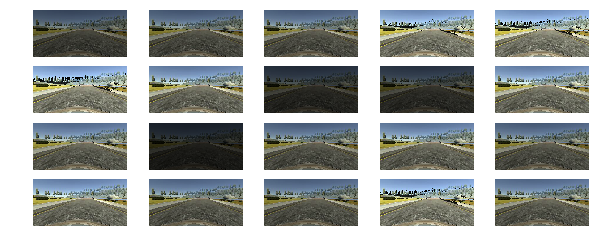

In [9]:
image2 = cv2.imread('Behavior_Cloning_Data/'+data_record['center'][1].strip())
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,5))
for i in range(20):
    image1 = augment_brightness(image2)
    plt.subplot(5,5,i+1)
    plt.imshow(image1)
    plt.axis('off')

### Augmentation 3: Shifting left/right and up/down
Processed images from this augmentation method simulate the effect of the car at different positions in the lane.

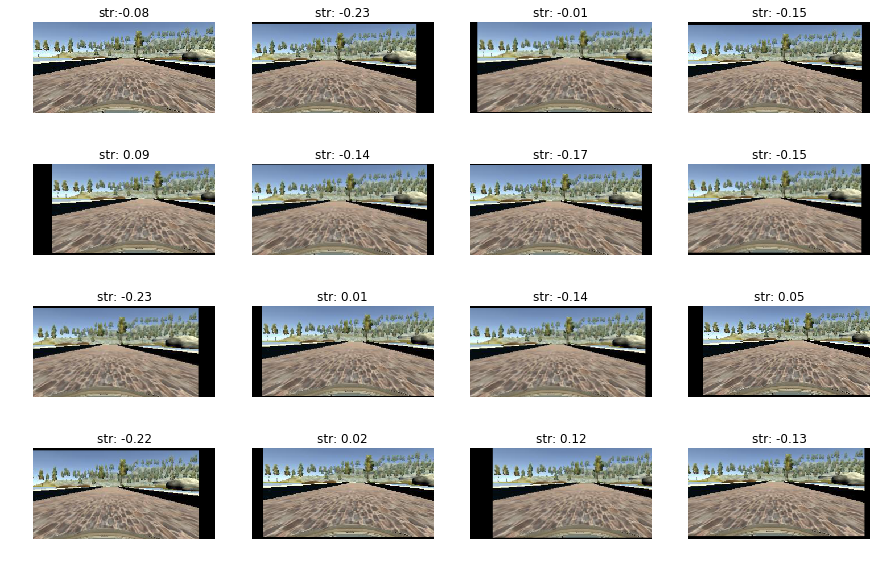

In [10]:
image = cv2.imread('Behavior_Cloning_Data/'+data_record['center'][80].strip())
steer = data_steer[80]
image_l = cv2.imread('Behavior_Cloning_Data/'+data_record['left'][80].strip())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)

# Translate the image 
def trans_image(image, steer, trans_range):
    trans_x = trans_range * np.random.uniform() - trans_range/2 # To get positive and negative shift
    steer_ang = steer + trans_x / trans_range * 2 * 0.2
    trans_y = 10 * np.random.uniform() - 10/2
    Trans_m = np.float32([[1,0,trans_x],[0,1,trans_y]])
    image_trans = cv2.warpAffine(image, Trans_m, (image.shape[1], image.shape[0]))
    
    return image_trans, steer_ang, trans_x
plt.figure(figsize = (15, 10))
plt.subplot(4,4,1)
plt.imshow(image)
plt.title('str:' + str(np.round(steer, 2)))
plt.axis('off')

for i in range(15):
    plt.subplot(4, 4, i+2)
    image_trans, steer_ang, trans_x = trans_image(image, steer, 80)
    plt.title('str: ' + str(np.round(steer_ang,2)))
    plt.imshow(image_trans)
    plt.axis('off');

### Augmentation 4: Flipping images
The output images from this augmentation method are flipped along the vertical axis to simulate the vehicle driving counterclockwise. The flipped images are chosen randomly. The corresponding steering angels are multiplied by -1 to make the vehicle steer to the opposite direction. Note, this augmentation is down using cv2.flip()

## Preprocessing

The following code is to show the examples of preprocessed images used as the input to the neural network. To further eliminate the unnecessary imformation and clean the image, I cropped the top 40% of the image and bottom 35 pixels for each image. The cropped image is reshaped to 128 x 128.

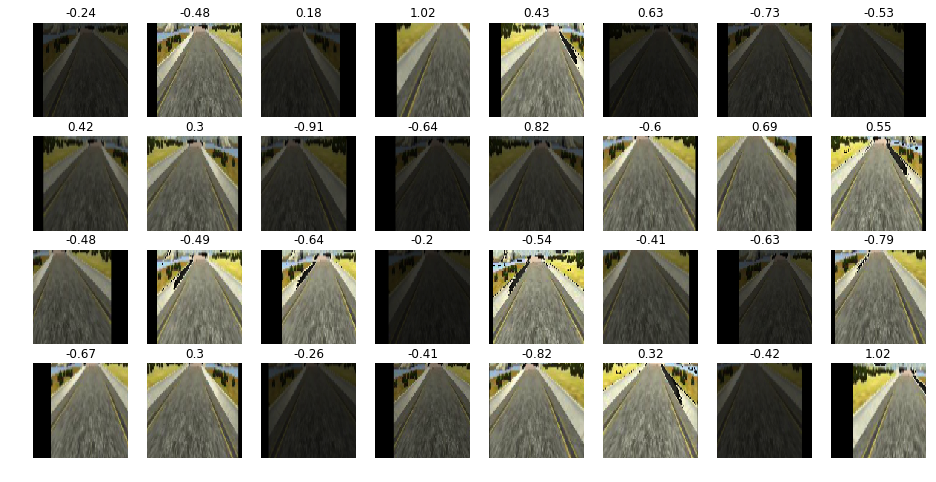

In [11]:
# Defint the size of the new image
new_image_col = 128
new_image_row = 128

def preprocessImage(image, new_image_col, new_image_row):
    image = image[math.floor(image.shape[0] * 0.4):(image.shape[0]-35), 0:image.shape[1]]
    image = cv2.resize(image,(new_image_row, new_image_col), interpolation = cv2.INTER_AREA)
    image = image/255. - 0.5
    return image
def preprocess_image_train(row_data):
    LR_token = np.random.randint(3)
    # Note: shift angle .25
    if LR_token == 0:
        path = 'Behavior_Cloning_Data/'+row_data['left'][0].strip()
        shift_ang = 0.25
    if LR_token == 1:
        path = 'Behavior_Cloning_Data/'+row_data['center'][0].strip()
        shift_ang = 0.
    if LR_token == 2:
        path = 'Behavior_Cloning_Data/'+row_data['right'][0].strip()
        shift_ang = -0.25
    steer = row_data['steering'][0] + shift_ang
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, steer_out, trans_x = trans_image(image, steer, 150)
    image = augment_brightness(image)
    image = preprocessImage(image, new_image_col, new_image_row)
    image = np.array(image)
    flip_token = np.random.randint(2)
    if flip_token == 0:
        image = cv2.flip(image,1)
        steer_out = -steer_out
    return image, steer_out
def preprocess_image_predict(row_data):
    path = 'Behavior_Cloning_Data/'+row_data['center'][0].strip()
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocessImage(image, new_image_col, new_image_row)
    image = np.array(image)
    return image

row_data = data_record.iloc[[5]].reset_index()
plt.figure(figsize=(16,8))
for i in range(32):
    image, steer = preprocess_image_train(row_data)
    plt.subplot(4,8,i+1)
    plt.imshow(image+0.5);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))
    
    

## Generator(Keras) and subsampling

This set of training data does not have a bias toward going straight. If it is, I would like to drop the images with small angles.

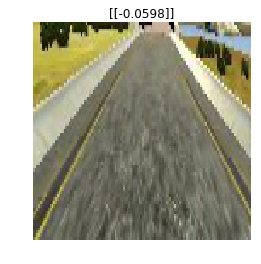

In [13]:
def generate_train_image(data, new_image_row, new_image_col,batch_size = 64, pr_threshold = 1):
    # Preallocate the memory
    batch_images = np.zeros((batch_size, new_image_row, new_image_col, 3))
    batch_steering = np.zeros(batch_size)
    # a forever running while loop for the generator
    while 1:
        for n_batch in range(batch_size):
            n_line = np.random.randint(len(data))
            row_data = data.iloc[[n_line]].reset_index()
            img, steer_ang = preprocess_image_train(row_data)
            batch_images[n_batch] = img
            batch_steering[n_batch] = steer_ang
        yield batch_images, batch_steering
def generate_valid_image(data):
    while 1:
        for n_line in range(len(data)):
            row_data = data.iloc[[n_line]].reset_index()
            image = preprocess_image_predict(data)
            image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
            steer = row_data['steering'][0]
            steer = np.array([[steer]])
            yield image, steer
valid_generator_ex = generate_valid_image(data_record)

for i in range(50):
    next(valid_generator_ex)
image, steer = next(valid_generator_ex)
plt.imshow(image[0]+0.5);
plt.axis('off')
plt.title(str(np.round(steer,4)));
                

## Model Architecture

### Fill some discription and attach a graph to explain the model architecture

In [16]:
import tensorflow as tf
# tf.python.control_flow_ops = tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import initializers

In [17]:
new_size_row = 128
new_size_col = 128

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x,input_shape=input_shape,output_shape=input_shape))

model.add(Conv2D(3, (1, 1), name="conv0",
       padding="valid", kernel_initializer="he_normal"))
model.add(ELU())

model.add(Conv2D(32, (filter_size, filter_size), name="conv1", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Conv2D(32, (filter_size, filter_size), name="conv2", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Conv2D(64, (filter_size, filter_size), name="conv3", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())

model.add(Conv2D(64, (filter_size, filter_size), name="conv4", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Conv2D(128, (filter_size, filter_size), name="conv5", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Conv2D(128, (filter_size, filter_size), name="conv6", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512, name="hidden1", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', kernel_initializer="he_normal"))
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam,
          loss='mse')

## Training 

In [18]:
from pathlib import Path
import json

def save_model(fileModelJSON,fileWeights):
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [ ]:
val_size = len(data_record)
pr_threshold = 1

batch_size = 256

i_best = 0
val_best = 1000
valid_generator = generate_valid_image(data_record)
for i_pr in range(10):

    train_generator = generate_train_image(data_record, new_size_row, new_size_col, batch_size)
   

    nb_vals = np.round(len(data_record)/val_size)-1
    history = model.fit_generator(train_generator, steps_per_epoch = np.round(len(data_record)/batch_size), epochs=1, verbose=1, callbacks=None, validation_data=valid_generator, 
                            validation_steps=np.round(len(data_record)/batch_size), class_weight=None, 
                            max_queue_size=10, workers=1, use_multiprocessing=False, initial_epoch=0)

    fileModelJSON = 'model_' + str(i_pr) + '.json'
    fileWeights = 'model_' + str(i_pr) + '.h5'

    save_model(fileModelJSON,fileWeights)

    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)


    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
